# AI WITH THE BEST

**In this part of the talk we will go through how to use Engineering expertise and Machine Learning for application to signal analysis and Virtual Sensors. We will not be able to go really deep into the subject, but please refer to this notebook if you want more details.** To use the notebook, please install, to the latest version, Numpy, Scikit-learn, Pandas, Tensorflow, and Neon

In [4]:
import numpy as np
import pandas as pd
from neon import NervanaObject
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from IPython.display import Image

In [6]:
from bokeh.layouts import column, gridplot
import bokeh.plotting as bk
bk.output_notebook()

Loading BokehJS ...

In [9]:
data = pd.read_csv('example_data/data.csv', parse_dates=['X0'])

**Building a model usually comprises few standard steps. In the course of this talk we will outline two of the main stages of a modeling pipeline, namely data preprocessing and model building (in this case a time series regression model for forecasting).**

## 1 Preprocessing

**Data preprocessing refers to all the steps necessary to transform raw data into an understandable and applicable format. This procedure is common to many Machine Learning (ML) and Data Mining tasks. In our work however we integrate into the process the Engineering knowledge of the system we are studying.** In the following sections we will briefly describe all the steps we usually perform on data with particular attention to Engineering point of view of signal processing. There could be other steps for example *feature elimination* is a common approach to reduce the dimensionality of a problem in an uninformed way. In our case the approach to *feature engineering* is indeed an engineering approach. We select the most informative features based on experience and problem specific know-how

**The steps covered will be:**
- Data Cleaning
- Filtering
- Resampling
- Transformation

### 1.1 Data Cleaning

**During this step we check for outliers, missing values and we try to resolve inconsistency of the data.**

As an example, in the next plot we can see that the quantity we are measuring w.r.t. time present some "holes". **In this case they correspond to NaN values in the data, meaning some values are not measured by the system. There are several ways to deal with this situation but they depend on the particular problem we are approaching.** In our case we often deal with time series data, with its own peculiarities.

**If the missing data comprise many values, as in this case, it is better to ignore them altogheter, we simply cut away NaNs. In the case of time series data this simple approach may be the best, since time series data are correlated to preceeding values, introducing synthetic values could cause the system to diverge or behave erratically. However if missing data consists of few points that are not contiguous, it is possible to interpolate and reconstruct the data. Even in this case, care must be taken because if the dynamic of the system varies with a frequency close to the sampling frequency, loosing a single data point may result in loosing a lot of information; on the contrary if the dynamic of the system is slow w.r.t. sampling frequency loosing few contiguous data points is not harmful.**

**If the signals come from a sensor and represent a physical quantity, it is possible to inspect the data to find faulty points or outliers and manually remove them.** For example some sensors have an automated diagnosis tool that output full-scale if they sense that they are faulty. Another sanity check that is performed is to compare the output of a sensor with a simple physical model that describes its behavior. If the two are roughly similar the signal is considered good. **Engineering experts knows the physics of the system and integrate this information  into the process of distinguishing between real outliers (value that are not physically possible to exist) and anomalous working conditions of the dynamic system that we still want to analyse.**

**For example, suppose that you are receiving acceleration and speed signals from a car (on a flat road); from physics we know that they are correlated, so if the two differs, for example speed is increasing while car is decelerating, the engineer can conclude that this measurement is an obviously an outlier.**

In [7]:
tools = 'pan,wheel_zoom,box_zoom,reset'

In [10]:
fig_a = bk.figure(plot_width=800, plot_height=350, 
                  x_axis_label='time',
                  y_axis_label='value',
                  x_axis_type='datetime', tools=tools)
fig_a.line(data['X0'], data['y'])
bk.show(fig_a)

The preceeding graph depicts a physical quantity that varies over time, and it is possible to see where data is missing. **It is worth pointing out that in real life scenarios *missing data is absolutely the rule* rather than the exception.**

## 1.2 Filtering

**Filtering is applied to time series and removes unwanted components from a signal.** It is used for removing noise or other components from the signal that are not meaningful from an engineering standpoint. To further clarify, **if we know that a signal represent a physical quantity that varies with a certain bandwidth of frequencies, removing the frequencies that are outside that bandwidth is important; moreover it is not harmful, because we have the knowledge that if we have a frequency outside it is certainly noise. Filtering is applied if and only if we have a prior knowledge of the system, otherwise cutting frequencies at random may remove information from the signal.**

**Let's look at an example. First we create two sine waves one with a frequency 2 Hz and the second with frequency 40 Hz. The third wave is the sum of the first two.**

In [11]:
from scipy.signal import butter
from scipy.signal import filtfilt, lfilter

In [12]:
fs = 2000
end = 4
t = np.arange(0, end, 1.0/fs)
x = []
for f in [2,40]:
    x.append(np.sin(2 * np.pi * f * t))

In [13]:
fig1 = bk.figure(plot_width=800, plot_height=200, 
                 x_axis_label='time',
                 y_axis_label='amplitude',
                 #x_axis_type='datetime', 
                 tools=tools)
fig1.line(t, x[0], legend='signal of interest')
fig2 = bk.figure(plot_width=800, plot_height=200, 
                 x_axis_label='time',
                 y_axis_label='amplitude',
                 #x_axis_type='datetime', 
                 x_range=fig1.x_range, tools=tools)
fig2.line(t, x[1], legend='noise')
fig3 = bk.figure(plot_width=800, plot_height=200,
                 x_axis_label='time',
                 y_axis_label='amplitude',
                 #x_axis_type='datetime', 
                 x_range=fig1.x_range, tools=tools)
fig3.line(t, x[0]+x[1], legend='signal+noise')
ha1 = bk.show(gridplot([[fig1], [fig2], [fig3]]))

**Now we filter the resulting signal at a frequency of 5 Hz, with a low pass filter. We want to recover the original 2 Hz signal. A low pass filter remove all the components with a frequency higher that the threshold.**

In [14]:
fcut = 5
order = 3
filter_type = 'lowpass'
b, a = butter(order, fcut/(fs/2.), filter_type)
x_acausal = filtfilt(b, a, x[0]+x[1])
x_causal = lfilter(b, a, x[0]+x[1])

In [15]:
fig1 = bk.figure(plot_width=800, plot_height=200, 
                 x_axis_label = 'time',
                 y_axis_label = 'amplitude',
                 #x_axis_type='datetime', 
                 tools=tools)
fig1.line(t, x_acausal, color='green', legend='non-causal filter')
fig1.line(t, x_causal, color='orange', legend='causal filter')
#fig1.line(t, x[0], legend='original signal')
fig2 = bk.figure(plot_width=800, plot_height=200, 
                 x_axis_label = 'time',
                 y_axis_label = 'amplitude',
                 #x_axis_type='datetime', 
                 x_range=fig1.x_range, tools=tools)
fig2.line(t, x[0], legend='original signal')
fig3 = bk.figure(plot_width=800, plot_height=200,
                 x_axis_label='time',
                 y_axis_label='amplitude',
                 #x_axis_type='datetime', 
                 x_range=fig1.x_range, tools=tools)
fig3.line(t, x[0]+x[1], legend='signal+noise')
ha1 = bk.show(gridplot([[fig3], [fig1], [fig2]]))

**There are several type of filters, in this example we used a causal and a non-causal lowpass filters.** The difference of the two approaches can be noted in the graph above. Causal means that the output depends only on the past input, while in non-causal filters the output depends also from future inputs. For this reason non-causal are better applied to offline processing, while causal filters introduces a delay. This can be clearly seen in the graph above. **In the first graph the green line represent the non-causal filter, and it correctly resemble the blue sinusoid in the graph underneath (it is the 2Hz signal). The orange line, instead, is the causal filter and the resulting sinusoid is equally good but delayed in time.**

## 1.3 Resampling

Usually data come from different sources. If the sources have different sampling frequency could be important to level out all of them before proceeding further on the analysis. **Resampling is the process of transforming a group signals with heterogeneous frequency in such a way that their sampling frequency becomes the same.**

**It is possible to perform resampling in two different ways, either adapt all the signals to the highest sampling frequency or to the lowest. The methods are called respectively *upsampling* and *downsampling*.**

Upsampling is an approximation of the signal as if it would have been sampled at a higher frequency. However a form of interpolation is required to "guess" the missing points. Interpolation can be performed in several ways, that can potentially introduce noise or wrong values. If we don't have an a-priori knowledge the less harmful ways to upsampling is to use a zero-order-hold (meaning we keep the last seen value as a constant thruough), or a linear interpolation.

Downsampling is the opposite operation and it consist of taking values of the function at a lower frequency. We don't need to interpolate in this case, but we have a frequency limit. The minimum sampling rate at which a signal can be sampled (without introducing errors), is twice the highest frequency of the signal. Otherwise we introduce another kind of error that is called aliasing.

**Let's look at an example. The first signal has a sample rate of 5 minutes while the other signal has a lower sample rate of 15 minutes. As can be seen zooming in the picture the dynamic of the first signal force us to keep its sampling frequency. Reducing sampling frequency in this case reduce the amount of information that we have. For this reason we upsample the second signal to the same sampling frequency. We use a zero-order-hold interpolation, that means using the last seen value as a constant for the values we interpolate.**

In [16]:
high = pd.read_csv('example_data/high_freq.csv', parse_dates=['X0'])
low = pd.read_csv('example_data/low_freq.csv', parse_dates=['X0'])

In [17]:
upsample = low.reset_index().drop_duplicates(subset='X0', keep='last').set_index('X0')
upsample = upsample.resample('5T').bfill(limit=1)
upsample = upsample.interpolate(limit=3)
upsample.dropna(inplace=True)

In [18]:
fig1 = bk.figure(plot_width=800, plot_height=200, x_axis_type='datetime', tools=tools)
fig1.line(high['X0'], high['X89'])
fig2 = bk.figure(plot_width=800, plot_height=200, x_axis_type='datetime', x_range=fig1.x_range, tools=tools)
fig2.line(low['X0'], low['y'])
fig3 = bk.figure(plot_width=800, plot_height=200, x_axis_type='datetime', x_range=fig1.x_range, tools=tools)
fig3.line(upsample.index, upsample['y'])
#fig3.line(data['X0'], data['y'])
ha1 = bk.show(gridplot([[fig1], [fig2], [fig3]]))

## 1.4 Transformation

**In ML practice, feature transformation is employed to ease computation of algorithms and improve their accuracy. Deep Learning has the ability to automatically create abstraction of data that resemble the feature transformation process. However in practical engineering applications we found that transforming the features knowing the physiscal mechanisms of the underling process, greatly improve the resulting deep learning or neural network model.**

Recall the example of a time series at the beginning of the notebook. **Forecasting a physical value over time, could make use of future reference to known quantities.** For example we know what day will be the next three days from now. **If our value has a cyclic behavior it is possible to take advantage of this knowledge and transform the time in a feature that we know in advance.** Moreover in our example the temperature is related to the time of the day and the period of the year in a cyclic fashion (we know that in a mid afternoon of a summer day the temperature is likely high!)

In [19]:
dayofweek = [o.dayofweek for o in data['X0']]
weekofyear = [o.week for o in data['X0']]
dayofyear = np.array([o.dayofyear for o in data['X0']])
dycos = -np.cos((dayofyear / 366.0) * 2 * np.pi)
minuteofday = np.array([o.minute + (o.hour * 60) for o in data['X0']])
mdcos = -np.cos((minuteofday / (24.0 * 60)) * 2 * np.pi)

In [20]:
fig1 = bk.figure(plot_width=800, plot_height=200, x_axis_type='datetime', tools=tools)
fig1.line(data['X0'], dycos)
fig2 = bk.figure(plot_width=800, plot_height=200, x_axis_type='datetime', x_range=fig1.x_range, tools=tools)
fig2.line(data['X0'], mdcos)
ha1 = bk.show(gridplot([[fig1], [fig2]]))

The previous graph depicts a transformation of *day of year* and *minute of day* with cosine function.

In practical machine learning usually there are a lot of methods for automatically perform feature extraction, such as dimensionality reduction methods (PCA, lle, t-sne), statistical transformation (standard scaling, normalization), feature discretizaion, non-linear expansion (using combination of polynomials of original features). All these methods can be successfully applied but we found that a good knowled of the physics and engineering aspects of the phenomena geatly improve accuracy and prediction capabilities. 

**We found that this is true even for algorithms that should learn features automatically (for example neural network and deep learning). If we have a priori knowledge of the underlying physical system, using this knowledge improves the accuracy of the model. So why shouldn't we use it!?**

## 2 Time series regression and forecasting

**In this section we will focus on constructing a model of a temporal series.** We assume that all preprocessing steps of previous section have been applyied. **Our goal is to predict what value a certain quantity will take few steps in the future.** This setting implies the use a regression algorithm to predict the numerical outcome of the temporal series. 

**The system we are studying is a building and we are trying to predict its internal temperature based on the measurements of a collection of sensors. The temperature itself is recorded by a sensor and its past values are thus available to the model.** Other measurements include the status of cooling and heating systems, as well as other environmental quantities. We will use both the temperature and the other exogenous inputs in the model; most of the signal past value will be available, but we can use engineered features such as the ones based on time that we have constructed in previous section. For example, suppose we want to know the value that the temperature will take the next hour. We know all past values of the temperature and the energy of the cooling system and other signals (exogenous inputs) up to now. However we can use future information as well, because we know all future value of our derived feature up to the time of prediction.

**We need to construct a model that takes into account the nonlinearity of the system and relates past values to future values of temperature.** In order to perform well, the model should see enough past value to predict the temperature but not too much to be misleaded. In general ML models are stateless, they see a point in space and decide the output of the model based on the features of that single point. **If we use a Multi Layer Perceptron (MLP) for example, we must provide it with lagged values in order to force it to take into account past history. Lagged values are portions of past history provided as a set of features to the algorithm. For example if we consider the past 3 values of a temperature to be meaningful for the algorithm we can reshape the dataset such that the feature at time t are the values of temperature at time t-1, t-2, t-3.** The use of lagged values, however, poses two kind of problems. **The choice of the number of past values to include is domain specific and it could be different for each feature (for example a feature needs 3 lagged values while another needs more); it is thus another hyperparameter to tune. Moreover using many lagged values increases the dimensionality of the problem and consequently the difficulty to find a model with desired accuracy.**

**For these reasons we use a different model of neural networks with loops that allows information of past values to persist inside the nodes. This kind of networks are called *Recurrent Neural Network (RNN)* and they are particularly useful for modeling and generating sequences.** They take time into account and they doesn't need to be manually fed with lagged values. **In particular we will use a kind of recurrent neural network called *Long Short Term Memory (LSTM)*.** One can think of a RNN as the same neural network that receive values from its predecessor.
One of the most intriguing features of **RNN is that they potentially recover dependencies of the current value from past data**. Sometimes RNNs need only recent information to recover the present, **however if** we need more context to recover the present, that is, **the gap between the relevant information and the point were it is important is high, RNNs become unable to learn.** Let's look at an RNN in more details. In the picture below we can see a simple RNN with a single input, output and recurrent unit.

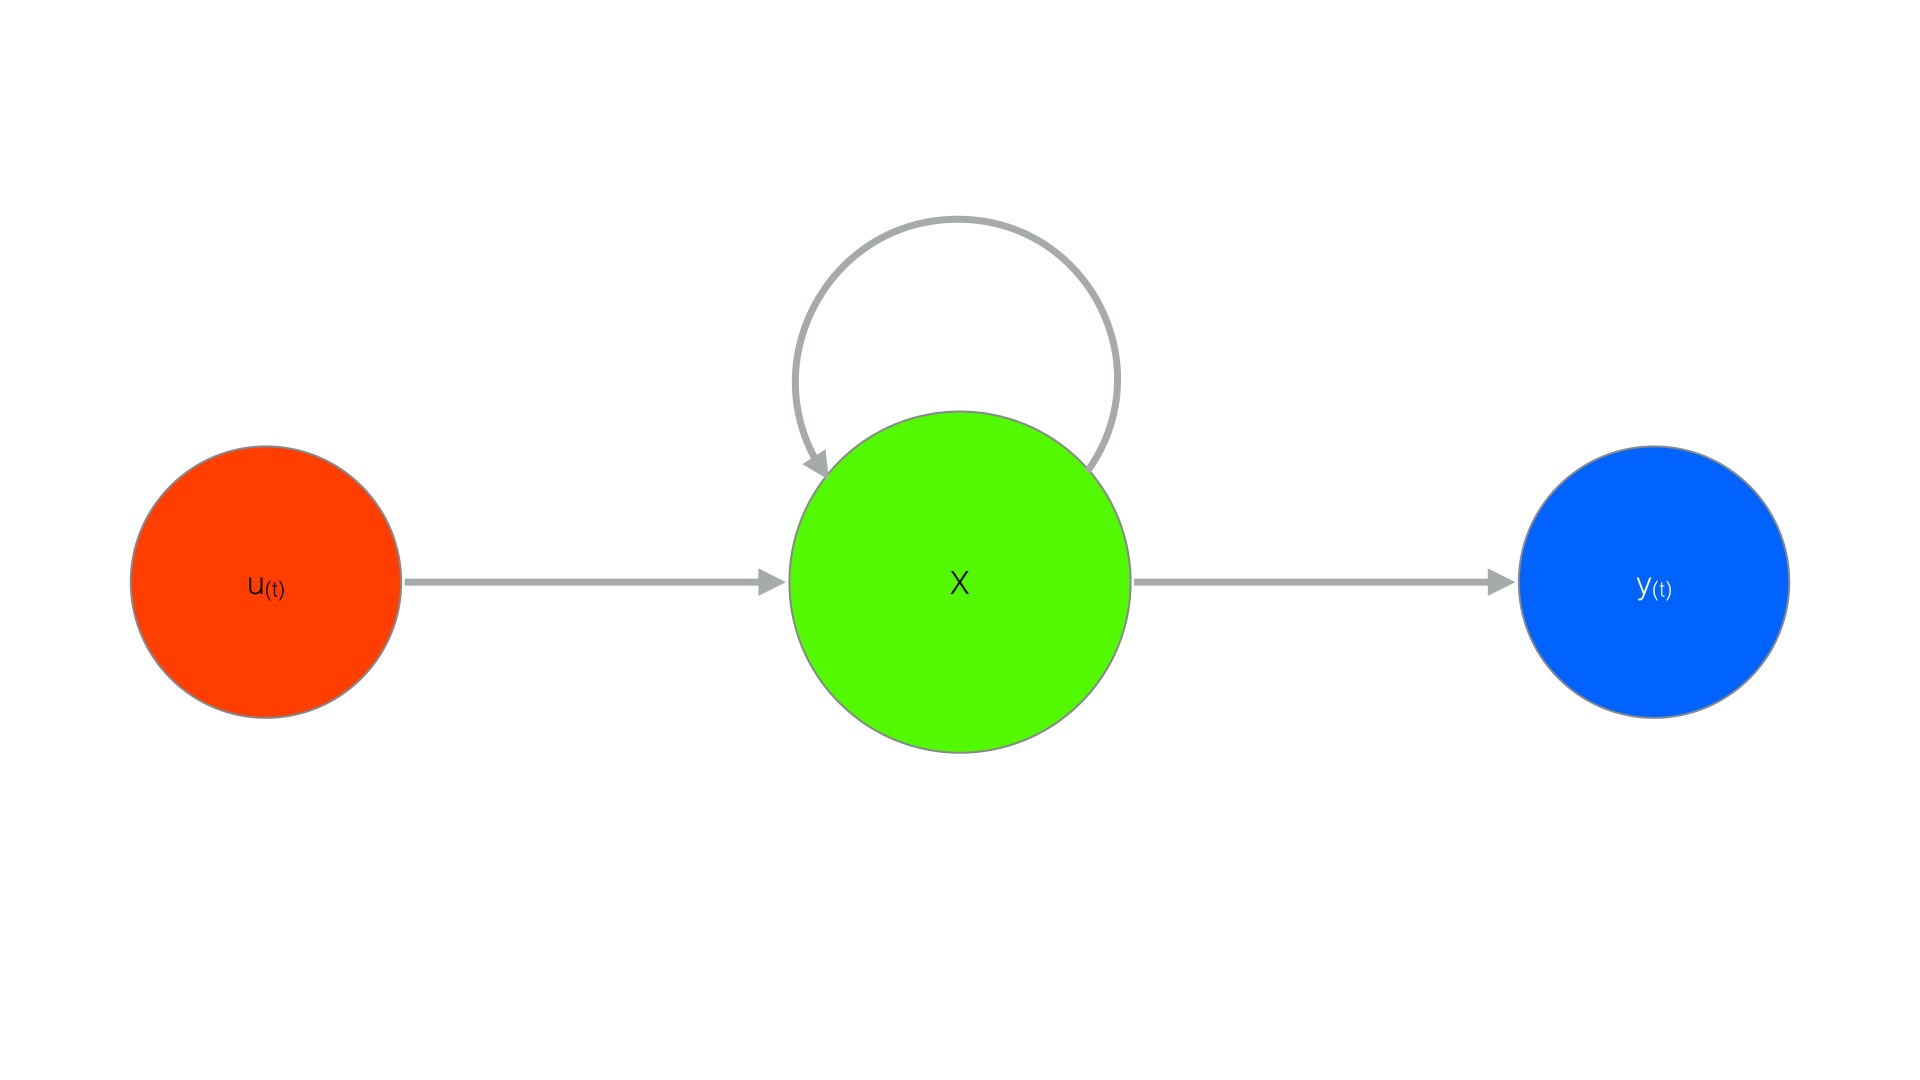

In [21]:
Image("images/simpleRNN.jpeg", width=400, height=400)

**If we unroll the network it as in picture below, the RNN looks like a series of copy of the same simple NN unit. Each copy receives the input from the previous.** We can see that inputs travel accross time; past input (blue node) is related to current input (red node). **However if the weight is less than one, as we travel along each time steps the effect of the input (blue node) diminishes as a function of the time interval between the two. On the contrary if the weight is greater than one the output will explode.**

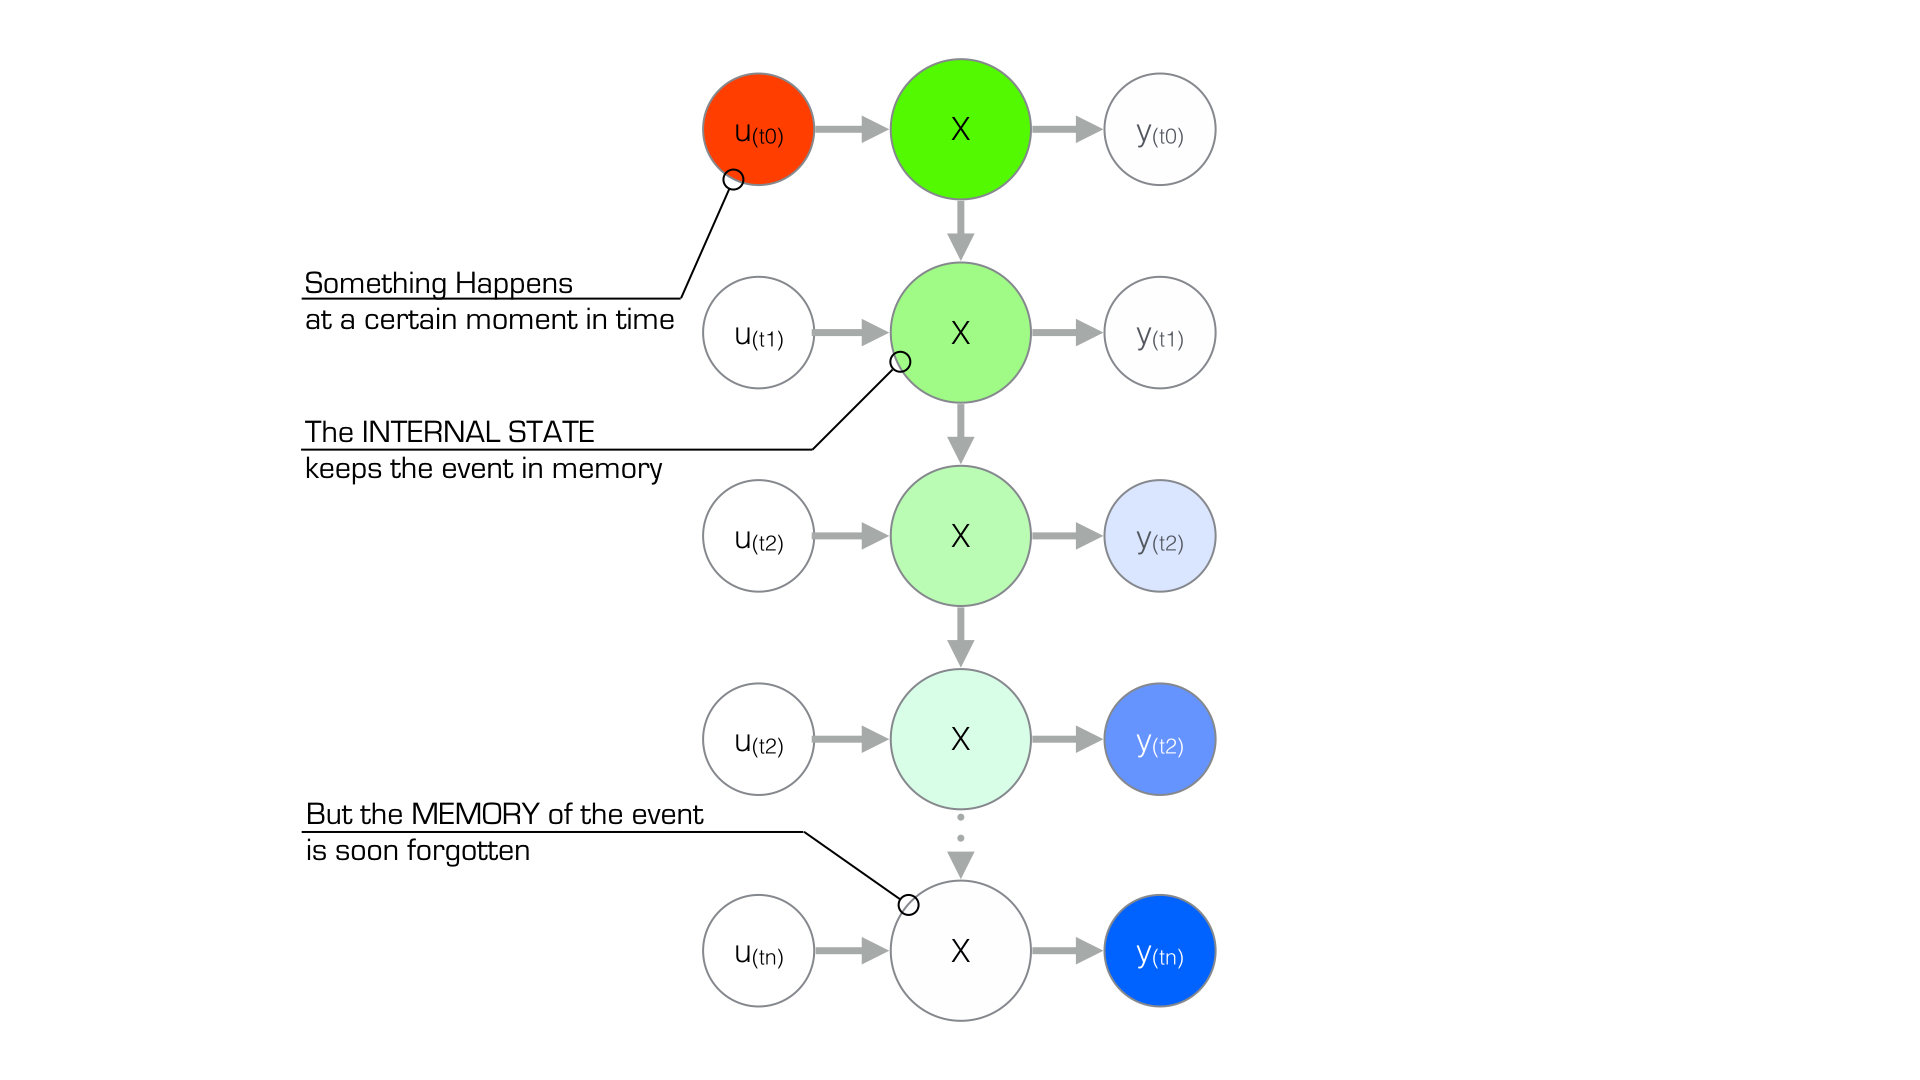

In [22]:
Image("images/unrolledRNN.jpeg", width=600, height=600)

**These problems are referred to as *vanishing* and *exploding gradient* ** and they are a serious problem in training recurrent neural networks. Many solutions have been proposed based on some sort of regularization such as Truncated Backpropagation Through Time (TBPTT). However the most successful RNN architecture that overcome the problem is LSTM. We will explain how it works in next section

### 2.2 LSTM

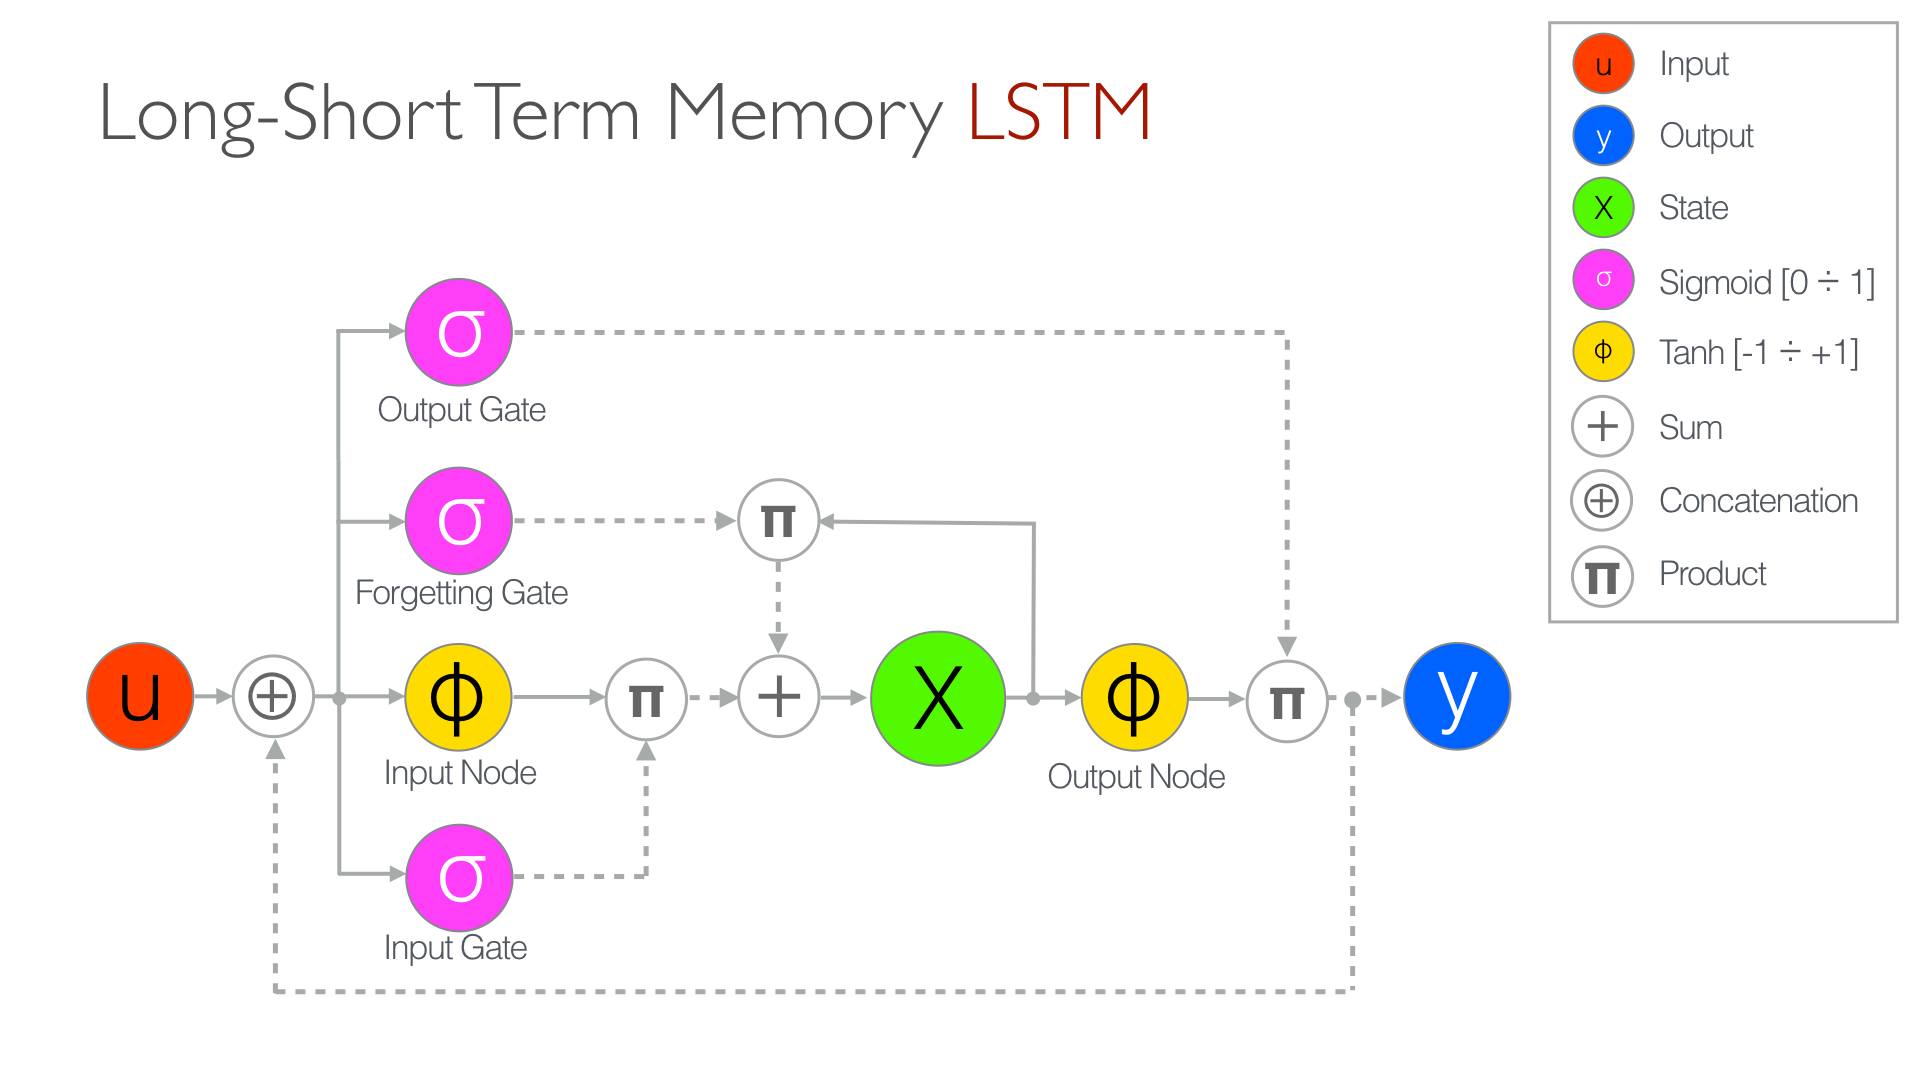

In [23]:
Image("images/LSTM.001.jpeg", width=700, height=700)

**LSTM networks looks like ordinary RNN, but they have an "internal state" that has a self-connected recurrent edge with weight 1. This edge spans adjacents time steps, ensuring that error can pass through time steps without vanishing or exploding.**

**The input node behaves like an ordinary neuron, it takes the current input and concatenate it with the output of the network at the preceeding time step. There are 3 other neurons, called gates that control how the flux of information passes through the network and persist in the internal state.** The input gate controls how information enter the system (modifying the internal state) and it is combined with input node. Output gate controls how the internal state affects the output. Finally the forget gate controls how past values of internal states are combined with the result from input gate and input node. All gates and node take as input the sum of current input and past network output.

Intuitively in the forward pass **LSTM can learn how to get input activation into internal state. If the input gate have 0 value, no input gate activation can enter the system. On the contrary if input gate saturate to 1, input activation modifies internal state. Similarly, the output gate learns when to let values out.** When both gates are closed, the internal state is not affected and persists throughout time steps neither increasing nor decreasing. In the backward pass the error can propagate back many steps unchanged (because weight is fixed at 1) neither exploding nor vanishing. The function of the gates is to learn when to let error in or out.

#### 2.2.1 Tensorboard

To better understand the computational graph of an LSTM it is possible to visualize how TensorFlow construct, using a tool called tensorboard. Tensorboard comes with TensorFlow installation and the computational graph is available if the model has logged the data. If you want to use it please run the notebook and then from the command line type: 
    
    tensorboard --logdir=tmp/
    
If you open the browser to the location suggested by the command and go to graph, you can zoom into the structure of the neural network and see its gates and the graph of operations it performs.

Here you can find the extract of the LSTM portion of the model

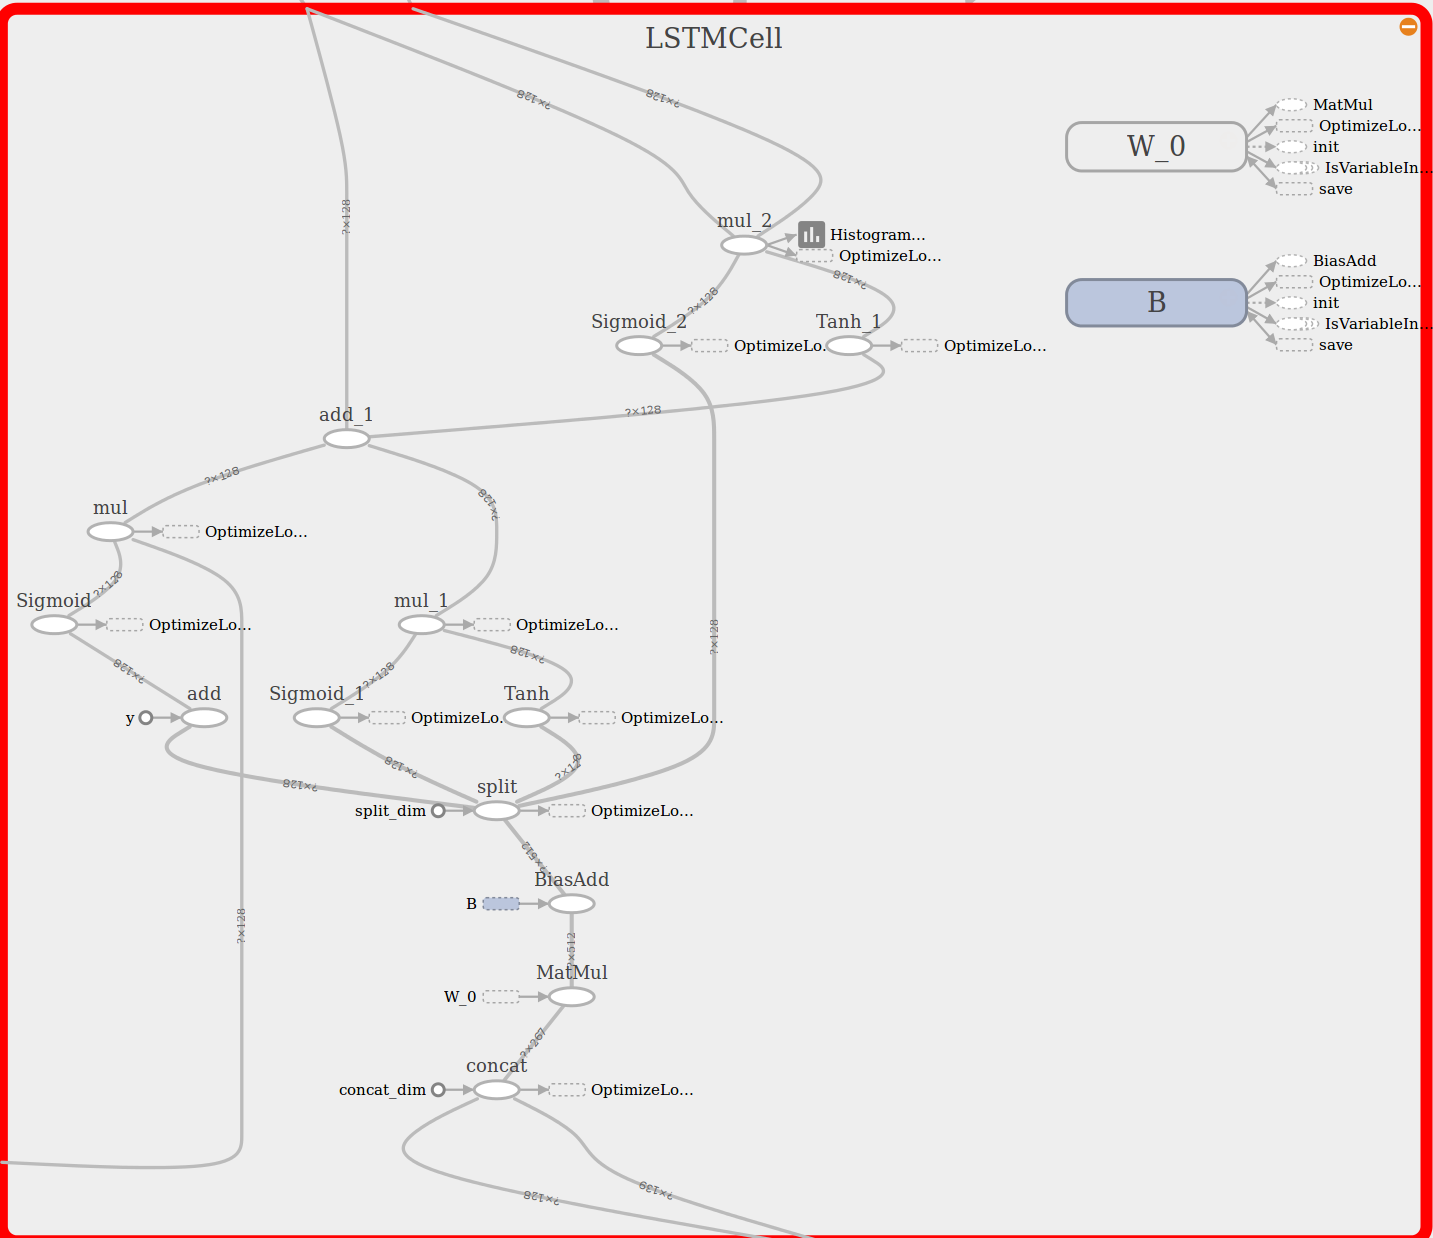

In [24]:
Image("images/tflstm.png", width=500, height=500)

### 2.3 Reading data

**The following code reads the data and generate the datasets for training and testing. We will set some of the hyperparameters that will be common to both models.**

In [25]:
data = pd.read_csv('example_data/data2.csv', parse_dates=['X0'])

**We choose to perform prediction of 12 steps ahead which means 1 hour in the future given a sampling rate of 5 minutes.** In this few lines of code we set the NN hyperparameters that will be equal to both models. **The number of hidden neuron and the batch size and the number of epochs for training remains the same.** Even if it is possible in principle that altering these two number allow one model to perform better than the other, we choose to use the same architecture settings in order to compare execution time as well. Sequence length represents the number of elements that we would like to use when classifying a sequence. It is especially useful when training a neural network to classify sentences, where sequence length represent the length of the sentence. In this setting were we want to predict a quantity we set sequence length to one (seq_len and n_steps represents the same quantity for the two libraries). Finally test sets and test size specify the number and perchentage of test sets we would like to use. In the context of time series analysis we prefer to choose the test sets to be at different location in time, to avoid overfitting a particular instant (for example if we chose to use as test set the end of the time serie)

In [26]:
prediction = 12
steps_forward = prediction
steps_backward = 0  # must be negative or zero
inputs_default = 0
hidden = 128
batch_size = 256
n_steps = seq_len = 1
epochs = 100
test_sets = 6
test_size = 0.2

As suggested at the beginning of this section it is possible to use future values of some features. In this case we can take advantage of this information and use lagged future values as with MLP. In practice the vector of regressors is extended with future values of some feature. Let's say we have feature *X1, X2, X3, X4* at time *t*. For some reason feature X4 can be determined for future values, so our new input a time t will be *X1, X2, X3, X4, X4(t+1), X4(t+2), X4(t+3), ...* and so forth. 

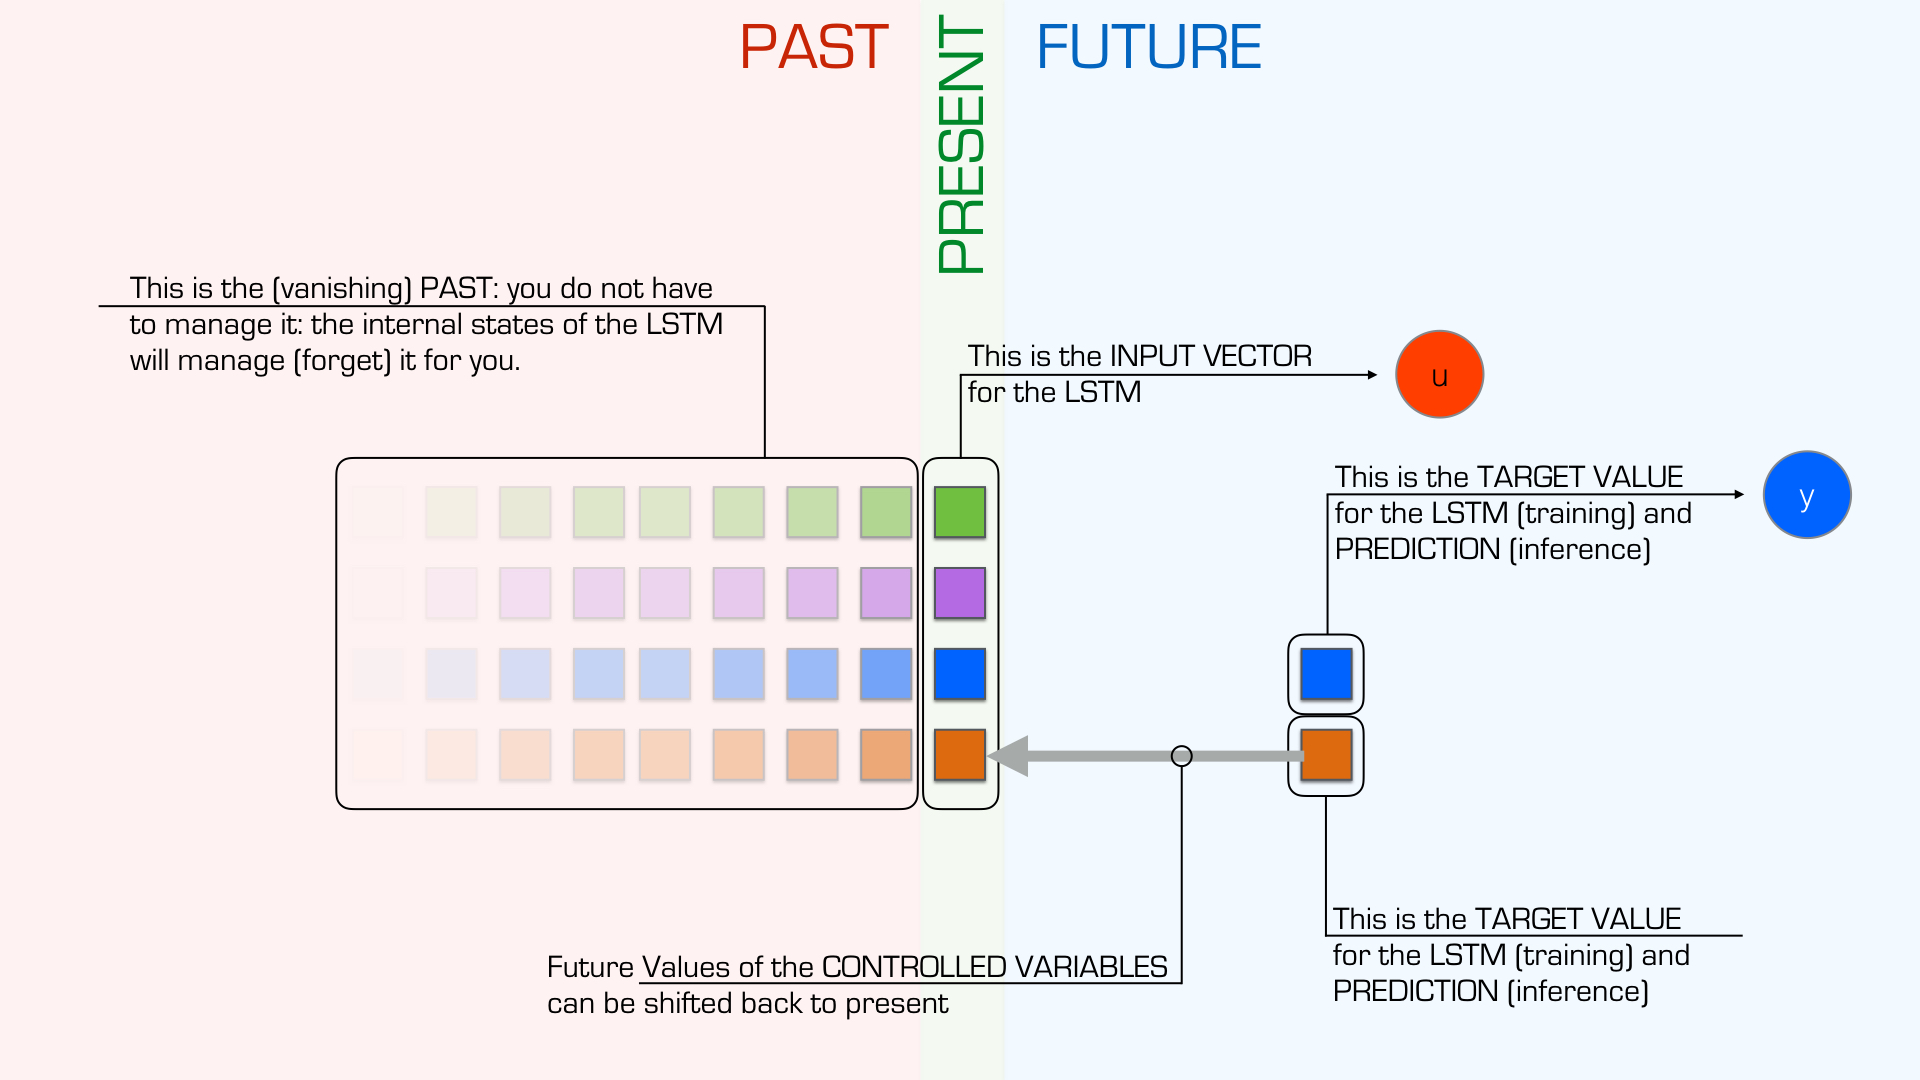

In [27]:
Image("images/lagged.jpeg", width=500, height=500)

**With the code below it is possible to specify the number of steps forward we want added to the inputs datasets. We choose to have a number of steps equal the number of steps in the future we want to predict.**

In [28]:
input_range = {
    'X109': [steps_backward, steps_forward],
    'X110': [steps_backward, steps_forward],
    'X111': [steps_backward, steps_forward],
    'X112': [steps_backward, steps_forward],
    'X70': [steps_backward, steps_forward],
    'X71': [steps_backward, steps_forward],
    'X73': [steps_backward, steps_forward],
    'X91': [steps_backward, steps_forward],
    'X92': [steps_backward, steps_forward],
    'X94': [steps_backward, steps_forward],
}

In the following code we choose the subset of columns that we want in the dataset, and the column that represent the target value.

In [29]:
X_columns = ['X109',  'X54', 'X53', 'X71', 'X112', 'X59', 'X111', 'X92', 'X66', 
             'X94', 'X73', 'X91', 'X110', 'X40', 'y', 'X47', 'X48', 'X70', 'X60']
y_column = 'y'

The following two functions generate the two main datasets. The first function creates X and y. In particular it shift the traget by the number of steps specified in prediction variable. This operation could be helpful to predict future values, where the prediction horizon is many steps ahead. The second function split the dataset in training and validation. The dataset is scaled to have zero mean and unit variance, otherwise the Network could be stuck in local minima during training. It is worth noting that using future values it is not strictly necessary, but sometimes it helps the model to have better accuracy. This can be seen as another parameter to set.

In [30]:
def gen_Xy(source, y_column, X_columns, inputs_per_column=None, inputs_default=3, steps_forward=1):
    y = source[y_column].shift(-steps_forward)
    scaler = StandardScaler()
    new_X = pd.DataFrame(scaler.fit_transform(source[X_columns]), columns=X_columns)
    X = pd.DataFrame()

    for column in X_columns:
        inputs = inputs_per_column.get(column, None)
        if inputs:
            inputs_list = range(inputs[0], inputs[1]+1)
        else:
            inputs_list = range(-inputs_default, 1)

        for i in inputs_list:
            col_name = "%s_%s" % (column, i)
            X[col_name] = new_X[column].shift(-i) # Note: shift direction is inverted

    X = pd.concat([X, y], axis=1)
    X.dropna(inplace=True, axis=0)
    y = X[y_column].values.reshape(X.shape[0], 1)
    X.drop([y_column], axis=1, inplace=True)

    return X.values, y


def split_Xy(X, y, test_size, sets=1):
    set_length = X.shape[0]/sets
    offset = 0
    X_train_lst = []
    y_train_lst = []
    X_test_lst = []
    y_test_lst = []
    for i in range(sets+1):
        offset = i*set_length
        tr_length = int(set_length*(1-test_size))
        tr_s = int(offset)
        tr_e = int(offset + tr_length)
        te_s = int(tr_e)
        te_e = int((i+1)*set_length)
        X_train_lst.append(X[tr_s:tr_e])
        y_train_lst.append(y[tr_s:tr_e])
        X_test_lst.append(X[te_s:te_e])
        y_test_lst.append(y[te_s:te_e])
    X_train = np.concatenate(X_train_lst)
    y_train = np.concatenate(y_train_lst)
    X_test = np.concatenate(X_test_lst)
    y_test = np.concatenate(y_test_lst)
    return X_train, y_train, X_test, y_test

**Now the dataset and the target are in the form of *numpy* arrays and they are further split in training and test sets.**

In [31]:
X, y = gen_Xy(source=data, y_column='y', X_columns=X_columns,
                           inputs_per_column=input_range, inputs_default=inputs_default,
                           steps_forward=prediction)

X_train, y_train, X_test, y_test = split_Xy(X, y, test_size, test_sets)

### 2.4 TensorFlow and Neon

In this section we will briefly review the two libraries that we will use for this exercise: Google TensorFlow and Nervana Neon. These two libraries are both opensource.

#### 2.4.1 Tensorflow
**[Tensorflow](https://www.tensorflow.org/ "TensorFlow")** was released by google in November, 2015. It **is a library for numerical computation on data flow graphs. Each node in the graph represents a mathematical operation, while the edges between nodes represent the multidimensional arrays (tensors) that flow between operations. Tensorflow is particularly suited for ML algorithm and it was designed to run on heterogeneous (and possibly distributed) resources.**

**Since it allows to express the computation from low level details it is possible to construct any kind of NN architecture. However during the time, some high level implementations of NN have been included in the library. In particular we will look at** former **SkFlow library** that has been moved in contrib/learn package of TensorFlow. SkFlow is a higher level library in the stile of scikit-learn, and allows a seamsless interaction with it. **It is possible to specify the NN topology at a higher level**, for example it is possible to use a LSTM layer without the cost of building all the gates and operations from skratch. We will use SkFlow in the example below.

#### 2.4.2 Neon
**[Neon](http://neon.nervanasys.com "Neon") is the Nervana's Python based library for Deep Learning. It is directly developed with NN in mind and for this reason it is easier to use and it provides higher level function for creating complex NN architectures. One of the goal of Neon is to provide great performance along ease of use. For this reason it works on selected Nvidia hardware or Nervana's hardware. It is also possible to use their Cloud service to run the code.** There is no need for other library if we want to explore its Deep Learning features.

### 2.5 TensforFlow implementation

**In this section we describe the implementation details of the TensorFlow model.** As usual we first import TensorFlow library and SkFlow. 

In [32]:
import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.contrib.learn.python import SKCompat

**By default TensorFlow run on available resources (in this case GPU)** and since version 0.8 it supports distributed computation. The code below limits memory usage to avoid complete GPU allocation to TensorFlow. It is needed in this context because the memory is note readily released by TensorFlow upon closing the session and the subsequent Neon code may get stuck with memory allocation exception. 

In [33]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

**SkFlow implementation allows to build a complex architecture with basic functions. For example we can build a Deep Neural Network** with the function *skflow.TensorFlowDNNClassifier*, that allows us to decide the number of layer and the number of neuron for each layer. This could limit the number of models we could train, but **with SkFlow it is possible to use custom function that accept X, y and return prediction and losses, and pass it to *skflow.TensorFlowEstimator*.**

**The following function build an LSTM Neural Network with a single layer and *hidden* number of neurons.** The first line of code perform some operations to the dataset to fit the needs of the LSTM cell. We specify the initializer because we would like to customize one of its parameters, however **most of the parameters are kept to the default value. We use *tf.nn.rnn_cell.LSTMCell* that implement the LSTM algorithm**, and we specify the number of neurons. We leave other parameters as deafault, but in principle it is possible to change activation function and add other variations to the base LSTM cell we described above.

**The last steps construct the RNN properly with *tf.nn.rnn*, with cell specified by lstm_cell. The output is further processed by the output layer that is a simple linear node, with *skflow.models.linear_regression* that builds a Tensor subgraph of that kind.**

It is however possible to build and customize model increasingly complex. For example we could simply add  *dropout* to the LSTM layer by adding a *tf.nn.rnn_cell.DropoutWrapper* or change the decay rate for the learning rate by adding a custom function instead of a scalar value. It is also possible to construct an even simpler model, for example a similar model could have been obtained with the function *skflow.TensorFlowRNNRegressor*.

In [34]:
def lstm_model(features, targets, mode, params):
    """Model function for Estimator."""
    features = tf.reshape(features, [-1, n_steps, n_input])  # (batch_size, n_steps, n_input)
    
    lstm_cell = tf.contrib.rnn.LSTMCell(hidden, state_is_tuple=True)
    output, _ = tf.nn.dynamic_rnn(cell=lstm_cell, inputs=features, dtype=tf.float32)
    
    target_shape = targets.get_shape()
    if len(target_shape) == 1:
        output_shape = 1
        targets = tf.reshape(targets, [-1, 1])
    else:
        output_shape = target_shape[1]

    output = tf.transpose(output, [1, 0, 2])
    last = tf.gather(output, int(output.get_shape()[0]) - 1)

    init = tf.random_normal_initializer(0, 0.1)

    weights = tf.get_variable('weights', [last.get_shape()[1], output_shape],
                              initializer=init,
                              dtype=tf.float32)
    bias = tf.get_variable('bias', [output_shape],
                           initializer=init,
                           dtype=tf.float32)

    predictions = tf.nn.xw_plus_b(last, weights, bias)

    # Calculate loss using mean squared error
    loss = tf.losses.mean_squared_error(predictions, targets)

    train_op = tf.contrib.layers.optimize_loss(
      loss=loss,
      global_step=tf.contrib.framework.get_global_step(),
      learning_rate=params["learning_rate"],
      optimizer="SGD")

    return predictions, loss, train_op

**The next step is to use *learn.Estimator* and build the custom model; watch out that in tensorflow steps are not epochs! Steps are the number of minibatches to process.** So we divide input size by batch size and multiply by the desired number of epochs. One of the parameters of the function is the optimizer used for updating the weights. The default value is Adagard. One more remark: to use it as a regression estimator you have to set n_classes to 0.

In [35]:
n_input = X_train.shape[1]
steps = (X_train.shape[0] / batch_size) * epochs  # steps is the number of batches to process
model = SKCompat(learn.Estimator(model_fn=lstm_model, params={'learning_rate':0.01}))

**Not all TensorFlow operations support float64 format so we convert all variables to type float32**

In [36]:
X_train = X_train.astype(np.float32).copy()
y_train = y_train.astype(np.float32).copy()
X_test = X_test.astype(np.float32).copy()
y_test = y_test.astype(np.float32).copy()
X, y = X.astype(np.float32).copy(), y.astype(np.float32).copy()

**Next we finally fit the model. Please make sure to create the *tmp* directory if it doesn't exist.**

In [37]:
%time model.fit(X_train, y_train, steps=5000)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


CPU times: user 52.2 s, sys: 4.02 s, total: 56.2 s
Wall time: 22.9 s


SKCompat()

**And last we predict the output for the training set and test set.**

In [38]:
y_train_predicted = model.predict(X_train)
trainScore = sqrt(mean_squared_error(y_train, y_train_predicted))
print('Train Score: %.2f RMSE' % (trainScore))
y_test_predicted = model.predict(X_test)
testScore = sqrt(mean_squared_error(y_test, y_test_predicted))
print('Test Score: %.2f RMSE' % (testScore))
y_hat = model.predict(X)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train Score: 0.22 RMSE


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Test Score: 0.27 RMSE


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [39]:
fig_b = bk.figure(plot_width=800, plot_height=350, 
                  x_axis_label='time',
                  y_axis_label='value',
                  tools=tools)
fig_b.line(range(len(y)), np.ravel(y), legend='true value')
fig_b.line(range(len(y_hat)), np.ravel(y_hat), color='orange', 
           legend='predicted value')
bk.show(fig_b)

The graph above depicts the true value (blue line) against the predicted value (orange line); as can be seen the orange line follows the blue line closely and the error is quite low. However it is possible to improve the model, for example if the train error is too low compared to the test error, it could be helpful include a form of regularization inside the model.

### 2.6 Nervana Neon implementation

**In this section we describe the details of the implementation with Neon.** It is possible to import only the neon module, but for clarity we import all the functions and objects that are necessary (to avoid writing every time neon.function).

In [40]:
from neon.backends import gen_backend
from neon.callbacks.callbacks import Callbacks
from neon.initializers import Gaussian
from neon.optimizers import RMSProp
from neon.layers import Linear, LSTM, RecurrentLast
from neon.transforms.activation import Tanh, Logistic
from neon.layers import GeneralizedCost
from neon.transforms import MeanSquared
from neon.models import Model
from neon import NervanaObject

DISPLAY:neon:mklEngine.dylib not found


**In Neon we first generate the computational backend, either based ong CPU or GPU hardware.**

In [42]:
return_sequences = False
be = gen_backend(backend='cpu', batch_size=int(batch_size), rng_seed=None, stochastic_round=False)

Also in this case we need to convert all variables to float32 because the **Neon GPU backend supports only float32 and float16.**

In [43]:
X_train = X_train.astype(np.float32).copy()
y_train = y_train.astype(np.float32).copy()
X_test = X_test.astype(np.float32).copy()
y_test = y_test.astype(np.float32).copy()
X, y = X.astype(np.float32).copy(), y.astype(np.float32).copy()

Neon has a peculiar way to load data into the backend and interact with it in the form of minibatches. Usually all we need is to define an *ArrayIterator* object. However **in the case of sequences we need to build a custom object that convert our data into a form suitable for RNN.** This involves constructing a multiple dimensional tensor of size: number of batches, batch size, time steps, and features. There are examples in the Neon source code that we customized to adapt to our case. 

In [44]:
def rolling_window(a, lag):
    """
    Convert a into time-lagged vectors a: (n, p)
    lag  : time steps used for prediction returns  (n-lag+1, lag, p)  array
    (Building time-lagged vectors is not necessary for neon.)
    """
    assert a.shape[0] > lag

    shape = [a.shape[0] - lag + 1, lag, a.shape[-1]]
    strides = [a.strides[0], a.strides[0], a.strides[-1]]
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


class DataIteratorSequence(NervanaObject):

    """
    This class takes a sequence and returns an iterator providing data in batches suitable for RNN
    prediction.  Meant for use when the entire dataset is small enough to fit in memory.
    """

    def __init__(self, X, y, time_steps, forward=1, return_sequences=True):
        """
        Implements loading of given data into backend tensor objects. If the backend is specific
        to an accelerator device, the data is copied over to that device.
        Args:
            X (ndarray): Input sequence with feature size within the dataset.
                         Shape should be specified as (num examples, feature size]
            time_steps (int): The number of examples to be put into one sequence.
            forward (int, optional): how many forward steps the sequence should predict. default
                                     is 1, which is the next example
            return_sequences (boolean, optional): whether the target is a sequence or single step.
                                                  Also determines whether data will be formatted
                                                  as strides or rolling windows.
                                                  If true, target value be a sequence, input data
                                                  will be reshaped as strides.  If false, target
                                                  value will be a single step, input data will be
                                                  a rolling_window
        """
        super(DataIteratorSequence, self).__init__(name=None)
        self.seq_length = time_steps
        self.forward = forward
        self.batch_index = 0
        self.nfeatures = self.nclass = X.shape[1]

        try:
            self.ntargets = y.shape[1]
        except:
            self.ntargets = 1

        self.nsamples = X.shape[0]
        self.shape = (self.nfeatures, time_steps)
        self.return_sequences = return_sequences

        target_steps = time_steps if return_sequences else 1
        # pre-allocate the device buffer to provide data for each minibatch
        # buffer size is nfeatures x (times * batch_size), which is handled by
        # backend.iobuf()
        self.X_dev = self.be.iobuf((self.nfeatures, time_steps))
        self.y_dev = self.be.iobuf((self.ntargets, target_steps))

        if return_sequences is True:
            # truncate to make the data fit into multiples of batches
            extra_examples = self.nsamples % (self.be.bsz * time_steps)
            if extra_examples:
                X = X[:-extra_examples]
                y = y[:-extra_examples]

            # calculate how many batches
            self.nsamples -= extra_examples
            self.nbatches = self.nsamples // (self.be.bsz * time_steps)
            self.ndata = self.nbatches * self.be.bsz * time_steps  # no leftovers

            # y is a new variable
            self.y_series = y
            # reshape this way so sequence is continuous along the batches
            self.X = X.reshape(self.be.bsz, self.nbatches,
                               time_steps, self.nfeatures)
            self.y = y.reshape(self.be.bsz, self.nbatches,
                               time_steps, self.ntargets)
        else:
            self.X = rolling_window(X, time_steps)
            self.X = self.X[:-1]
            # self.y = X[time_steps:]
            self.y = y[time_steps:]

            self.nsamples = self.X.shape[0]
            extra_examples = self.nsamples % self.be.bsz
            if extra_examples:
                self.X = self.X[:-extra_examples]
                self.y = self.y[:-extra_examples]

            # calculate how many batches
            self.nsamples -= extra_examples
            self.nbatches = self.nsamples // self.be.bsz
            self.ndata = self.nbatches * self.be.bsz
            self.y_series = self.y

            Xshape = (self.nbatches, self.be.bsz, time_steps, self.nfeatures)
            Yshape = (self.nbatches, self.be.bsz, target_steps, self.ntargets)
            self.X = self.X.reshape(Xshape).transpose(1, 0, 2, 3)
            self.y = self.y.reshape(Yshape).transpose(1, 0, 2, 3)

    def reset(self):
        """
        For resetting the starting index of this dataset back to zero.
        """
        self.batch_index = 0

    def __iter__(self):
        """
        Generator that can be used to iterate over this dataset.
        Yields:
            tuple : the next minibatch of data.
        """
        self.batch_index = 0
        while self.batch_index < self.nbatches:
            # get the data for this batch and reshape to fit the device buffer
            # shape
            X_batch = self.X[:, self.batch_index].reshape(
                self.X_dev.shape[::-1]).T.copy()
            y_batch = self.y[:, self.batch_index].reshape(
                self.y_dev.shape[::-1]).T.copy()

            # make the data for this batch as backend tensor
            self.X_dev.set(X_batch)
            self.y_dev.set(y_batch)

            self.batch_index += 1

            yield self.X_dev, self.y_dev

def same_len_trans(a, b):  # accessory function
    offset = a.shape[0] - b.shape[0]
    if offset > 0:
        a = a[:-offset]
    elif offset < 0:
        b = b[:offset]

    return a,b


class Namespace:
    pass


def make_stop_function(p): # early stopping stop function
    ns = Namespace()
    ns.patience = p

    def stop_function(s, v):
        if s is None:
            return v, False
        if v > s:
            ns.patience -= 1
            if ns.patience == 0:
                return min(v, s), True
        return min(v, s), False

    return stop_function

**Now *train_set* and *test_set* contain the predictor variables, the response variable and can be analyzed one batch at the time.**

In [45]:
train_set = DataIteratorSequence(
    X_train, y_train, seq_len, return_sequences=return_sequences)
test_set = DataIteratorSequence(
    X_test, y_test, seq_len, return_sequences=return_sequences)

**The next lines of code set up the init object that initialize the weight of the network and the optimizer that will update the weights based on the gradient.**

In [46]:
init_norm = Gaussian(loc=0.0, scale=0.05)
optimizer = RMSProp(learning_rate=0.005, decay_rate=0.9, epsilon=1e-6)

**Next we build the netwrok with a single LSTM layer (the parameters are the same as the tensorflow model) and a linear output. In Neon however there is one more layer, *RecurrentLast* in this case, that keeps only the last output of the recurrent layer (otherwise the recurrent layer will output all the sequence).** Note the *reset_cells=True* parameter that makes the LSTM layer stateless across minibatches. This is useful only if we want the network to learn a sequence that spans multiple minibatches.

In [47]:
layers = [
    LSTM(hidden, init_norm, activation=Logistic(),
         gate_activation=Tanh(), reset_cells=True),
    RecurrentLast(),
    Linear(nout=y_train.shape[1], init=init_norm)
]

**The next code block specifies the cost function, then it construct the model and add callbacks if any (in this case we are not using any callback, but we could add a regularization term like early stopping). The last statement actually launch the fitting of the Neural Network.**

In [48]:
cost = GeneralizedCost(costfunc=MeanSquared())
mlp = Model(layers=layers)
callbacks = Callbacks(mlp, eval_set=test_set, eval_freq=1, progress_bar=False)
# callbacks.add_early_stop_callback(make_stop_function(2))
%time mlp.fit(train_set, optimizer=optimizer, num_epochs=epochs, cost=cost, callbacks=callbacks)

CPU times: user 1min 31s, sys: 6.48 s, total: 1min 38s
Wall time: 49.3 s


**And last we predict the output for the training set and test set.**

In [49]:
y_train_pred = mlp.get_outputs(train_set)
y_test_pred = mlp.get_outputs(test_set)
y_train_pred = y_train_pred.ravel()
y_test_pred = y_test_pred.ravel()
y_test, y_test_pred = same_len_trans(y_test, y_test_pred)
y_train, y_train_pred = same_len_trans(y_train, y_train_pred)

score_train = sqrt(mean_squared_error(y_train, y_train_pred))
print('Train Score: %.2f RMSE' % (score_train))
score_test = sqrt(mean_squared_error(y_test, y_test_pred))
print('Test Score: %.2f RMSE' % (score_test))

Train Score: 0.26 RMSE
Test Score: 0.30 RMSE


In order to plot the predicted value for the whole dataset we need to construct a DataIteratorSequence object for the whole dataset.

In [50]:
data_set = DataIteratorSequence(X, y, seq_len, return_sequences=return_sequences)
y_hat = mlp.get_outputs(data_set)

In [51]:
fig_b = bk.figure(plot_width=800, plot_height=350, 
                  x_axis_label='time',
                  y_axis_label='value',
                  tools=tools)
fig_b.line(range(len(y)), np.ravel(y), legend='true value')
fig_b.line(range(len(y_hat)), np.ravel(y_hat), color='orange', legend='predicted value')
bk.show(fig_b)

The graph above depicts the true value (blue line) against the predicted value (orange line); as can be seen the orange line follows the blue line closely and the error is low. However there is still room for improvement since the predicted value has come high frequency components that could be removed. It possible to change the network topology and try to further optimize the hyperparameters, but even when the network doesn't follow closely the time series its error is almost always below 0.5.

### 2.7 Neon and TensorFlow comparison

TensorFlow with skflow is simple like other high level libraries (namely scikit-learn). If the model is non-standard it is possible to modify it in several different ways, however for complex model it is better to go back to barebone TensorFlow. Execution time is not the best feature of TensorFlow, but it has the advantage that could be seamlessly distributed over resources. 

Neon it is developed directly with NN in mind and thus its interface it is already a high level one. It allows to specify the backend, the model, how to initialize weights, and what kind of optimization to use. The interface is simple as said, but allows for great modularity. Each module has most if not all the modern algorithms. Neon website host also a "zoo" of pretrained modules. 

Comparing the precision of both libraries shows that they reach the sam accuracy. It's worth noting that for skflow we used most of the default parameters and we got a good accuracy. For Neon we had to perfrom an brief hyperparameter optimization to reach the same results. Execution time in this case is not intended to be a full benchmark, because the model is too simple. However we can see that even in this case Neon execution time is 30% faster compared to that on TensorFlow.

One more thing to note is that TensorFlow since its realease has grown in popularity an now it is easy to find tutorials and high level code (as SkFlow suggests). Neon on the contrary has a good documentation albeit sometimes it has few use case examples. 

---

Visit [www.add-for.com](<http://www.add-for.com/IT>) for more tutorials and updates.

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.